In [1]:
import pandas as pd
import numpy
import requests
import json
import datetime
import dateutil.parser
import pytz
from typing import Optional, Union
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# An api key is emailed to you when you sign up to a plan
# Get a free API key at https://api.the-odds-api.com/
API_KEY = 'ccb83d4bc10da89dbfa3dc2135ba9c1a'

SPORT = 'upcoming' # use the sport_key from the /sports endpoint below, or use 'upcoming' to see the next 8 games across all sports

REGIONS = 'us' # uk | us | eu | au. Multiple can be specified if comma delimited

MARKETS = 'h2h' # h2h | spreads | totals. Multiple can be specified if comma delimited

ODDS_FORMAT = 'american' # decimal | american

DATE_FORMAT = 'iso' # iso | unix

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# First get a list of in-season sports
#   The sport 'key' from the response can be used to get odds in the next request
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

sports_response = requests.get(
    'https://api.the-odds-api.com/v4/sports',
    params={
        'api_key': API_KEY
    }
)


if sports_response.status_code != 200:
    print(f'Failed to get sports: status_code {sports_response.status_code}, response body {sports_response.text}')

else:
    print('List of in season sports:', sports_response.json())


List of in season sports: [{'key': 'americanfootball_cfl', 'group': 'American Football', 'title': 'CFL', 'description': 'Canadian Football League', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf', 'group': 'American Football', 'title': 'NCAAF', 'description': 'US College Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf_championship_winner', 'group': 'American Football', 'title': 'NCAAF Championship Winner', 'description': 'US College Football Championship Winner', 'active': True, 'has_outrights': True}, {'key': 'americanfootball_nfl', 'group': 'American Football', 'title': 'NFL', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_preseason', 'group': 'American Football', 'title': 'NFL Preseason', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_super_bowl_winner', 'group': 'American Football', 'title': 'NFL Super Bowl Winner'

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# Now get a list of live & upcoming games for the sport you want, along with odds for different bookmakers
# This will deduct from the usage quota
# The usage quota cost = [number of markets specified] x [number of regions specified]
# For examples of usage quota costs, see https://the-odds-api.com/liveapi/guides/v4/#usage-quota-costs

SPORT = 'baseball_mlb'

odds_response = requests.get(
    f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds',
    params={
        'api_key': API_KEY,
        'regions': REGIONS,
        'markets': MARKETS,
        'oddsFormat': ODDS_FORMAT,
        'dateFormat': DATE_FORMAT,
    }
)

if odds_response.status_code != 200:
    print(f'Failed to get odds: status_code {odds_response.status_code}, response body {odds_response.text}')

else:
    odds_json = odds_response.json()
    print('Number of events:', len(odds_json))
    print(odds_json)


Number of events: 25
[{'id': 'b4e1686fcee2a6a9d35d30a7f27a0a9f', 'sport_key': 'baseball_mlb', 'sport_title': 'MLB', 'commence_time': '2024-08-09T22:46:00Z', 'home_team': 'Washington Nationals', 'away_team': 'Los Angeles Angels', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'last_update': '2024-08-09T22:48:16Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-09T22:48:16Z', 'outcomes': [{'name': 'Los Angeles Angels', 'price': -108}, {'name': 'Washington Nationals', 'price': -118}]}]}, {'key': 'betonlineag', 'title': 'BetOnline.ag', 'last_update': '2024-08-09T22:46:43Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-09T22:46:43Z', 'outcomes': [{'name': 'Los Angeles Angels', 'price': -114}, {'name': 'Washington Nationals', 'price': 104}]}]}, {'key': 'lowvig', 'title': 'LowVig.ag', 'last_update': '2024-08-09T22:45:13Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-09T22:45:13Z', 'outcomes': [{'name': 'Los Angeles Angels', 'price': -112}, {'name': 'Washington National

In [5]:
# Check the usage quota
print('Remaining requests', odds_response.headers['x-requests-remaining'])
print('Used requests', odds_response.headers['x-requests-used'])


Remaining requests 481
Used requests 19


In [6]:
#set up the columns
columns = [
        'event_id', 'sport_key', 'sport_title', 'commence_time',
        'home_team', 'away_team', 'bookmaker_key', 'bookmaker_title',
        'bookmaker_last_update', 'market_key', 'market_last_update',
        'outcome_name', 'outcome_price']

df2 = pd.DataFrame(columns=columns)

# Prepare list to collect all rows
all_rows = []

# Iterate over each event
for event in odds_json:
        event_id = event['id']
        sport_key = event['sport_key']
        sport_title = event['sport_title']
        commence_time = event['commence_time']
        home_team = event['home_team']
        away_team = event['away_team']

        # Iterate over each bookmaker
        for bookmaker in event['bookmakers']:
            bookmaker_key = bookmaker['key']
            bookmaker_title = bookmaker['title']
            bookmaker_last_update = bookmaker['last_update']

            # Iterate over each market
            for market in bookmaker['markets']:
                market_key = market['key']
                market_last_update = market['last_update']

                # Iterate over each outcome
                for outcome in market['outcomes']:
                    outcome_name = outcome['name']
                    outcome_price = outcome['price']

                    # Append the row to the list
                    all_rows.append([
                        event_id, sport_key, sport_title, commence_time,
                        home_team, away_team, bookmaker_key, bookmaker_title,
                        bookmaker_last_update, market_key, market_last_update,
                        outcome_name, outcome_price
                    ])
for i, row in enumerate(all_rows):
    df2.loc[i] = row

In [7]:
df2

,event_id,sport_key,sport_title,commence_time,home_team,away_team,bookmaker_key,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,b4e1686fcee2a6a9d35d30a7f27a0a9f,baseball_mlb,MLB,2024-08-09T22:46:00Z,Washington Nationals,Los Angeles Angels,fanduel,FanDuel,2024-08-09T22:48:16Z,h2h,2024-08-09T22:48:16Z,Los Angeles Angels,-108
1,b4e1686fcee2a6a9d35d30a7f27a0a9f,baseball_mlb,MLB,2024-08-09T22:46:00Z,Washington Nationals,Los Angeles Angels,fanduel,FanDuel,2024-08-09T22:48:16Z,h2h,2024-08-09T22:48:16Z,Washington Nationals,-118
2,b4e1686fcee2a6a9d35d30a7f27a0a9f,baseball_mlb,MLB,2024-08-09T22:46:00Z,Washington Nationals,Los Angeles Angels,betonlineag,BetOnline.ag,2024-08-09T22:46:43Z,h2h,2024-08-09T22:46:43Z,Los Angeles Angels,-114
3,b4e1686fcee2a6a9d35d30a7f27a0a9f,baseball_mlb,MLB,2024-08-09T22:46:00Z,Washington Nationals,Los Angeles Angels,betonlineag,BetOnline.ag,2024-08-09T22:46:43Z,h2h,2024-08-09T22:46:43Z,Washington Nationals,104
4,b4e1686fcee2a6a9d35d30a7f27a0a9f,baseball_mlb,MLB,2024-08-09T22:46:00Z,Washington Nationals,Los Angeles Angels,lowvig,LowVig.ag,2024-08-09T22:45:13Z,h2h,2024-08-09T22:45:13Z,Los Angeles Angels,-112
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,864cd8352c4ac3c547d6b98d532b75cc,baseball_mlb,MLB,2024-08-11T01:41:00Z,Seattle Mariners,New York Mets,lowvig,LowVig.ag,2024-08-09T22:48:13Z,h2h,2024-08-09T22:48:13Z,Seattle Mariners,-127
386,864cd8352c4ac3c547d6b98d532b75cc,baseball_mlb,MLB,2024-08-11T01:41:00Z,Seattle Mariners,New York Mets,draftkings,DraftKings,2024-08-09T22:48:12Z,h2h,2024-08-09T22:48:12Z,New York Mets,110
387,864cd8352c4ac3c547d6b98d532b75cc,baseball_mlb,MLB,2024-08-11T01:41:00Z,Seattle Mariners,New York Mets,draftkings,DraftKings,2024-08-09T22:48:12Z,h2h,2024-08-09T22:48:12Z,Seattle Mariners,-130
388,864cd8352c4ac3c547d6b98d532b75cc,baseball_mlb,MLB,2024-08-11T01:41:00Z,Seattle Mariners,New York Mets,williamhill_us,Caesars,2024-08-09T22:48:15Z,h2h,2024-08-09T22:48:15Z,New York Mets,110


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 389
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   event_id               390 non-null    object
 1   sport_key              390 non-null    object
 2   sport_title            390 non-null    object
 3   commence_time          390 non-null    object
 4   home_team              390 non-null    object
 5   away_team              390 non-null    object
 6   bookmaker_key          390 non-null    object
 7   bookmaker_title        390 non-null    object
 8   bookmaker_last_update  390 non-null    object
 9   market_key             390 non-null    object
 10  market_last_update     390 non-null    object
 11  outcome_name           390 non-null    object
 12  outcome_price          390 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 50.8+ KB


In [9]:
df2.duplicated().sum()

0

In [10]:
df2.duplicated().value_counts()

,count
False,390


In [11]:
df2.drop_duplicates(inplace=True)

In [12]:
df2.duplicated().sum()

0

In [13]:
df2.isnull().sum()

,0
event_id,0
sport_key,0
sport_title,0
commence_time,0
home_team,0
away_team,0
bookmaker_key,0
bookmaker_title,0
bookmaker_last_update,0
market_key,0


In [14]:
df2= df2.drop(columns = ['event_id', 'commence_time', 'bookmaker_key'])
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,2024-08-09T22:48:16Z,h2h,2024-08-09T22:48:16Z,Los Angeles Angels,-108
1,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,2024-08-09T22:48:16Z,h2h,2024-08-09T22:48:16Z,Washington Nationals,-118
2,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,2024-08-09T22:46:43Z,h2h,2024-08-09T22:46:43Z,Los Angeles Angels,-114
3,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,2024-08-09T22:46:43Z,h2h,2024-08-09T22:46:43Z,Washington Nationals,104
4,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,LowVig.ag,2024-08-09T22:45:13Z,h2h,2024-08-09T22:45:13Z,Los Angeles Angels,-112
...,...,...,...,...,...,...,...,...,...,...
385,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,2024-08-09T22:48:13Z,h2h,2024-08-09T22:48:13Z,Seattle Mariners,-127
386,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,2024-08-09T22:48:12Z,h2h,2024-08-09T22:48:12Z,New York Mets,110
387,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,2024-08-09T22:48:12Z,h2h,2024-08-09T22:48:12Z,Seattle Mariners,-130
388,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,2024-08-09T22:48:15Z,h2h,2024-08-09T22:48:15Z,New York Mets,110


In [15]:
# Convert the columns to datetime
df2['bookmaker_last_update'] = pd.to_datetime(df2['bookmaker_last_update'])
df2['market_last_update'] = pd.to_datetime(df2['market_last_update'])

# Format the datetime columns
df2['bookmaker_last_update'] = df2['bookmaker_last_update'].dt.strftime('%b %d, %H:%M')
df2['market_last_update'] = df2['market_last_update'].dt.strftime('%b %d, %H:%M')
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Los Angeles Angels,-108
1,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Washington Nationals,-118
2,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Los Angeles Angels,-114
3,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Washington Nationals,104
4,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,LowVig.ag,"Aug 09, 22:45",h2h,"Aug 09, 22:45",Los Angeles Angels,-112
...,...,...,...,...,...,...,...,...,...,...
385,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-127
386,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110
387,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130
388,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 389
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sport_key              390 non-null    object
 1   sport_title            390 non-null    object
 2   home_team              390 non-null    object
 3   away_team              390 non-null    object
 4   bookmaker_title        390 non-null    object
 5   bookmaker_last_update  390 non-null    object
 6   market_key             390 non-null    object
 7   market_last_update     390 non-null    object
 8   outcome_name           390 non-null    object
 9   outcome_price          390 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 41.6+ KB


In [17]:
def av_odds(df2):
    # Define key columns for grouping
    key_fields = ['home_team', 'away_team', 'bookmaker_title', 'outcome_name']

    # Perform aggregation by calculating the average outcome_price
    df_avg = df2.groupby(key_fields, dropna=False).agg({
        'outcome_price': 'mean'  # Average outcome_price
    }).reset_index()

    # Sort the aggregated DataFrame by key fields
    df_avg.sort_values(['home_team','away_team'], inplace=True)

    return df_avg



In [18]:
df_avg_odds = av_odds(df2)
df_avg_odds

,home_team,away_team,bookmaker_title,outcome_name,outcome_price
0,Arizona Diamondbacks,Philadelphia Phillies,BetMGM,Arizona Diamondbacks,115.0
1,Arizona Diamondbacks,Philadelphia Phillies,BetMGM,Philadelphia Phillies,-135.0
2,Arizona Diamondbacks,Philadelphia Phillies,BetOnline.ag,Arizona Diamondbacks,3.0
3,Arizona Diamondbacks,Philadelphia Phillies,BetOnline.ag,Philadelphia Phillies,-13.0
4,Arizona Diamondbacks,Philadelphia Phillies,BetRivers,Arizona Diamondbacks,118.0
...,...,...,...,...,...
275,Washington Nationals,Los Angeles Angels,FanDuel,Washington Nationals,-113.0
276,Washington Nationals,Los Angeles Angels,LowVig.ag,Los Angeles Angels,-109.0
277,Washington Nationals,Los Angeles Angels,LowVig.ag,Washington Nationals,-1.0
278,Washington Nationals,Los Angeles Angels,MyBookie.ag,Los Angeles Angels,-110.5


In [19]:
#general average odds for the home team only
avg_odds = df2.groupby('home_team')['outcome_price'].mean()
avg_odds

,outcome_price
home_team,
Arizona Diamondbacks,-28.366667
Boston Red Sox,-8.550000
Chicago White Sox,-12.071429
Colorado Rockies,-11.600000
Kansas City Royals,-21.400000
Los Angeles Dodgers,-19.766667
Miami Marlins,-10.031250
Milwaukee Brewers,-9.633333
Minnesota Twins,-62.192308


In [20]:
#standard deviationon the home team only
std_dev_odds = df2.groupby('home_team')['outcome_price'].std()
std_dev_odds

,outcome_price
home_team,
Arizona Diamondbacks,116.796753
Boston Red Sox,127.201239
Chicago White Sox,168.030405
Colorado Rockies,161.438490
Kansas City Royals,114.869521
Los Angeles Dodgers,169.477836
Miami Marlins,141.219912
Milwaukee Brewers,138.210106
Minnesota Twins,92.230155


In [21]:
#min and max odds sorted by outcome_price
min_odds = df2.groupby('outcome_name')['outcome_price'].min().sort_values()
max_odds = df2.groupby('outcome_name')['outcome_price'].max().sort_values(ascending=False)

print("**Minimum Odds:**")
print(min_odds)
print("")
print("**Maximum Odds:**")
print(max_odds)

**Minimum Odds:**
outcome_name
Chicago Cubs            -245
Los Angeles Dodgers     -214
San Francisco Giants    -205
Atlanta Braves          -195
San Diego Padres        -180
Toronto Blue Jays       -160
Milwaukee Brewers       -158
Baltimore Orioles       -145
Philadelphia Phillies   -140
Boston Red Sox          -136
Seattle Mariners        -135
Kansas City Royals      -135
Los Angeles Angels      -130
Minnesota Twins         -124
Pittsburgh Pirates      -120
Washington Nationals    -120
Arizona Diamondbacks    -115
Cleveland Guardians     -111
St. Louis Cardinals     -103
New York Mets            110
Tampa Bay Rays           110
Miami Marlins            111
Houston Astros           112
Cincinnati Reds          114
Oakland Athletics        118
Chicago White Sox        120
Colorado Rockies         135
Detroit Tigers           155
Name: outcome_price, dtype: int64

**Maximum Odds:**
outcome_name
Chicago White Sox        210
Pittsburgh Pirates       180
Detroit Tigers           174
Colo

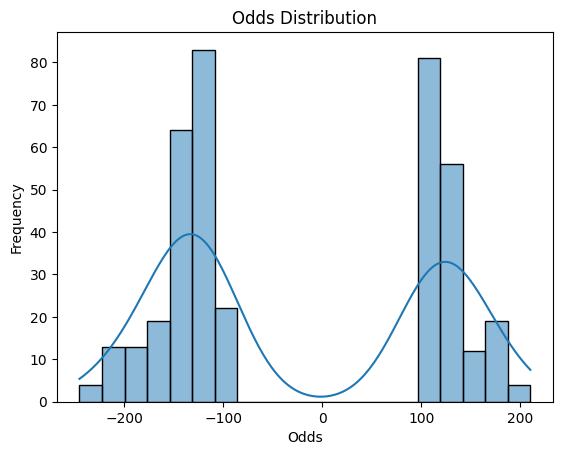

In [22]:
#number of times each team is placed within the odds
sns.histplot(df2['outcome_price'], bins=20, kde=True)
plt.xlabel('Odds')
plt.ylabel('Frequency')
plt.title('Odds Distribution')
plt.show()


In [23]:
home_odds = df2[df2['home_team'] == 'TeamName']['outcome_price'].mean()
away_odds = df2[df2['away_team'] == 'TeamName']['outcome_price'].mean()
print(home_odds)
print(away_odds)

nan
nan


In [23]:
# Grouping by 'bookmaker_title' and including 'home_team'
bookmaker_odds = df2.groupby(['bookmaker_title', 'home_team'])['outcome_price'].apply(list).reset_index()

# Display the odds
bookmaker_odds


,bookmaker_title,home_team,outcome_price
0,BetMGM,Arizona Diamondbacks,"[115, -135]"
1,BetMGM,Boston Red Sox,"[-135, 115]"
2,BetMGM,Chicago White Sox,"[-145, 120]"
3,BetMGM,Colorado Rockies,"[-165, 140]"
4,BetMGM,Kansas City Royals,"[-120, 100]"
...,...,...,...
135,MyBookie.ag,San Francisco Giants,"[171, -204]"
136,MyBookie.ag,Seattle Mariners,"[113, -133]"
137,MyBookie.ag,Tampa Bay Rays,"[-132, 112]"
138,MyBookie.ag,Toronto Blue Jays,"[130, -154, 120, -147]"


In [24]:
def calculate_implied_probability(odd):
    if odd < 0:
        return ((-1 * odd) / ((-1 * odd) + 100)) * 100
    else:
        return (100 / (odd + 100)) * 100

In [25]:
# Apply the function to calculate implied probability and add it to the DataFrame
df2['implied_probability'] = df2['outcome_price'].apply(calculate_implied_probability)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability
0,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Los Angeles Angels,-108,51.923077
1,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Washington Nationals,-118,54.128440
2,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Los Angeles Angels,-114,53.271028
3,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Washington Nationals,104,49.019608
4,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,LowVig.ag,"Aug 09, 22:45",h2h,"Aug 09, 22:45",Los Angeles Angels,-112,52.830189
...,...,...,...,...,...,...,...,...,...,...,...
385,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-127,55.947137
386,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048
387,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130,56.521739
388,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048


In [26]:
def calculate_vigor(row):
    home_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['home_team'])]['implied_probability'].values[0]
    away_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['away_team'])]['implied_probability'].values[0]
    vigor = home_team_implied_prob + away_team_implied_prob - 100
    return f"{vigor:.2f}%"

#Apply the function to calculate overround for each bookmaker
df2['vigor'] = df2.apply(calculate_vigor, axis=1)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor
0,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Los Angeles Angels,-108,51.923077,6.05%
1,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Washington Nationals,-118,54.128440,6.05%
2,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Los Angeles Angels,-114,53.271028,2.29%
3,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,BetOnline.ag,"Aug 09, 22:46",h2h,"Aug 09, 22:46",Washington Nationals,104,49.019608,2.29%
4,baseball_mlb,MLB,Washington Nationals,Los Angeles Angels,LowVig.ag,"Aug 09, 22:45",h2h,"Aug 09, 22:45",Los Angeles Angels,-112,52.830189,2.34%
...,...,...,...,...,...,...,...,...,...,...,...,...
385,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-127,55.947137,2.05%
386,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048,4.18%
387,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130,56.521739,4.18%
388,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048,4.14%


In [27]:
df2['vigor'] = df2['vigor'].str.replace('%', '').astype(float)

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 389
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sport_key              390 non-null    object 
 1   sport_title            390 non-null    object 
 2   home_team              390 non-null    object 
 3   away_team              390 non-null    object 
 4   bookmaker_title        390 non-null    object 
 5   bookmaker_last_update  390 non-null    object 
 6   market_key             390 non-null    object 
 7   market_last_update     390 non-null    object 
 8   outcome_name           390 non-null    object 
 9   outcome_price          390 non-null    int64  
 10  implied_probability    390 non-null    float64
 11  vigor                  390 non-null    float64
 12  vig_spread             390 non-null    float64
dtypes: float64(3), int64(1), object(9)
memory usage: 50.8+ KB


In [40]:
vigor_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='vigor')
vigor_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,Caesars,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,,
Arizona Diamondbacks,3.96,2.05,4.03,2.05,4.60,4.20,4.14,4.07,2.05,4.07
Atlanta Braves,3.93,2.16,3.70,2.51,4.24,4.09,4.20,4.14,2.16,4.14
Baltimore Orioles,4.64,1.99,3.69,1.99,4.47,4.20,4.18,4.14,1.99,4.07
Boston Red Sox,3.96,2.01,3.69,1.99,4.43,3.96,4.18,3.92,2.01,3.96
Chicago Cubs,4.64,2.14,3.86,2.73,4.25,4.25,4.32,3.93,2.14,3.96
Chicago White Sox,4.64,2.14,3.86,2.73,4.25,4.25,4.32,3.93,2.14,3.96
Cincinnati Reds,4.64,2.14,3.61,2.55,4.34,4.26,4.26,4.11,2.14,3.99
Cleveland Guardians,4.71,2.27,3.85,2.44,4.76,4.55,4.76,3.84,2.27,4.08
Colorado Rockies,3.93,2.16,3.70,2.51,4.24,4.09,4.20,4.14,2.16,4.14


In [41]:
low_vig = df2[df2['vigor'] <=2.05][['outcome_name', 'vigor','bookmaker_title']].sort_values('vigor')
low_vig

,outcome_name,vigor,bookmaker_title
28,Baltimore Orioles,1.99,LowVig.ag
288,Miami Marlins,1.99,BetOnline.ag
289,San Diego Padres,1.99,BetOnline.ag
290,Miami Marlins,1.99,LowVig.ag
291,San Diego Padres,1.99,LowVig.ag
84,Miami Marlins,1.99,LowVig.ag
83,San Diego Padres,1.99,BetOnline.ag
82,Miami Marlins,1.99,BetOnline.ag
75,Houston Astros,1.99,BetUS
74,Boston Red Sox,1.99,BetUS


In [42]:
#Calculate the vig spread of the highest and lowest bookmaker
df2['vig_spread'] = df2.groupby(['outcome_name'])['vigor'].transform(lambda x: x.max() - x.min())
df2.tail(10)

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor,vig_spread
380,baseball_mlb,MLB,Seattle Mariners,New York Mets,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048,4.14,2.37
381,baseball_mlb,MLB,Seattle Mariners,New York Mets,FanDuel,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130,56.521739,4.14,2.37
382,baseball_mlb,MLB,Seattle Mariners,New York Mets,BetOnline.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,117,46.082949,2.05,2.37
383,baseball_mlb,MLB,Seattle Mariners,New York Mets,BetOnline.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-127,55.947137,2.05,2.37
384,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,117,46.082949,2.05,2.37
385,baseball_mlb,MLB,Seattle Mariners,New York Mets,LowVig.ag,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-127,55.947137,2.05,2.37
386,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048,4.18,2.37
387,baseball_mlb,MLB,Seattle Mariners,New York Mets,DraftKings,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130,56.521739,4.18,2.37
388,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,"Aug 09, 22:48",h2h,"Aug 09, 22:48",New York Mets,110,47.619048,4.14,2.37
389,baseball_mlb,MLB,Seattle Mariners,New York Mets,Caesars,"Aug 09, 22:48",h2h,"Aug 09, 22:48",Seattle Mariners,-130,56.521739,4.14,2.37


In [43]:
#highest to smallest vigor spread as percentages
print(df2[['outcome_name', 'vig_spread']].drop_duplicates().sort_values('vig_spread', ascending=False))

              outcome_name  vig_spread
0       Los Angeles Angels        4.68
1     Washington Nationals        4.68
256         Detroit Tigers        2.89
257   San Francisco Giants        2.89
21          Tampa Bay Rays        2.65
20       Baltimore Orioles        2.65
217     Pittsburgh Pirates        2.62
216    Los Angeles Dodgers        2.62
196   Arizona Diamondbacks        2.55
197  Philadelphia Phillies        2.55
100           Chicago Cubs        2.50
101      Chicago White Sox        2.50
120        Cincinnati Reds        2.50
121      Milwaukee Brewers        2.50
140    Cleveland Guardians        2.49
141        Minnesota Twins        2.49
80           Miami Marlins        2.48
81        San Diego Padres        2.48
60          Boston Red Sox        2.44
61          Houston Astros        2.44
156     Kansas City Royals        2.39
157    St. Louis Cardinals        2.39
236          New York Mets        2.37
237       Seattle Mariners        2.37
41       Toronto Blue Jay

In [44]:
Implied_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='implied_probability')
Implied_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,Caesars,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,,
Arizona Diamondbacks,46.511628,49.338624,45.871560,46.296296,48.076923,49.679966,50.553710,49.546444,49.338624,47.169811
Atlanta Braves,62.264151,62.490886,62.546816,60.317460,61.685824,63.820078,63.792743,64.053803,62.490886,62.121212
Baltimore Orioles,59.183673,56.331878,56.521739,56.331878,57.081545,58.333333,57.446809,56.521739,56.331878,56.896552
Boston Red Sox,57.446809,56.140351,56.521739,56.331878,57.264957,57.446809,57.446809,57.627119,56.140351,57.446809
Chicago Cubs,59.183673,64.498495,60.000000,58.677686,60.000000,60.000000,65.345956,64.913337,64.498495,59.514170
Chicago White Sox,45.454545,37.774054,43.859649,44.052863,44.247788,44.247788,38.988095,39.130697,37.774054,44.444444
Cincinnati Reds,45.454545,43.769113,45.454545,42.553191,43.103448,44.994944,45.103616,44.674910,43.769113,43.668122
Cleveland Guardians,51.219512,48.780488,51.923077,51.456311,52.606635,50.000000,51.190476,50.000000,48.780488,52.153110
Colorado Rockies,41.666667,39.647094,41.152263,42.194093,42.553191,40.360565,40.417210,40.092373,39.647094,42.016807


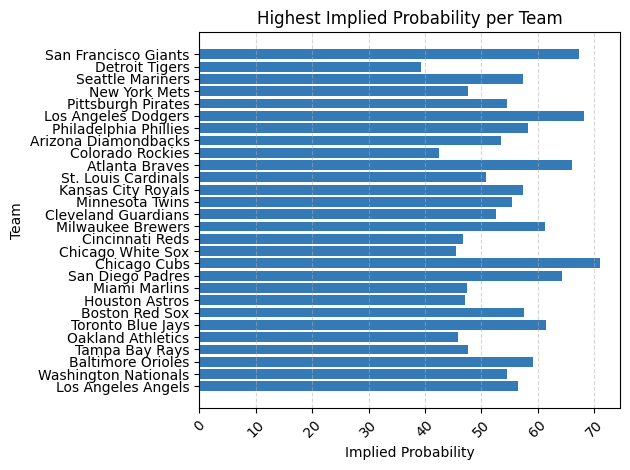

In [56]:
# Assuming the data is in a pandas dataframe called `df`
teams = df2['outcome_name']
implied_probabilities = df2['implied_probability']

plt.barh(teams, implied_probabilities, color='#337ab7')  # blue bars
plt.xlabel('Implied Probability')
plt.ylabel('Team')
plt.title('Highest Implied Probability per Team')
plt.grid(axis='x', linestyle='--', alpha=0.5)  # add a grid
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.tight_layout()  # adjust layout to fit all labels
plt.show()

In [52]:
#Maximum implied probability for all teams
print(df2.loc[df2.groupby('outcome_name')['implied_probability'].idxmax()][['outcome_name', 'implied_probability']])

              outcome_name  implied_probability
356   Arizona Diamondbacks            53.488372
368         Atlanta Braves            66.101695
26       Baltimore Orioles            59.183673
70          Boston Red Sox            57.627119
348           Chicago Cubs            71.014493
113      Chicago White Sox            45.454545
318        Cincinnati Reds            46.728972
150    Cleveland Guardians            52.606635
185       Colorado Rockies            42.553191
260         Detroit Tigers            39.215686
77          Houston Astros            47.169811
338     Kansas City Royals            57.446809
6       Los Angeles Angels            56.521739
232    Los Angeles Dodgers            68.152866
98           Miami Marlins            47.393365
139      Milwaukee Brewers            61.240310
323        Minnesota Twins            55.357143
236          New York Mets            47.619048
284      Oakland Athletics            45.871560
205  Philadelphia Phillies            58

In [43]:
print(df_avg_odds.head())
print(f'Number of rows in aggregated DataFrame: {df_avg_odds.shape[0]}')


              home_team              away_team bookmaker_title  \
0  Arizona Diamondbacks  Philadelphia Phillies          BetMGM   
1  Arizona Diamondbacks  Philadelphia Phillies          BetMGM   
2  Arizona Diamondbacks  Philadelphia Phillies    BetOnline.ag   
3  Arizona Diamondbacks  Philadelphia Phillies    BetOnline.ag   
4  Arizona Diamondbacks  Philadelphia Phillies       BetRivers   

            outcome_name  outcome_price  
0   Arizona Diamondbacks          120.0  
1  Philadelphia Phillies         -145.0  
2   Arizona Diamondbacks            2.0  
3  Philadelphia Phillies          -12.0  
4   Arizona Diamondbacks          114.0  
Number of rows in aggregated DataFrame: 274


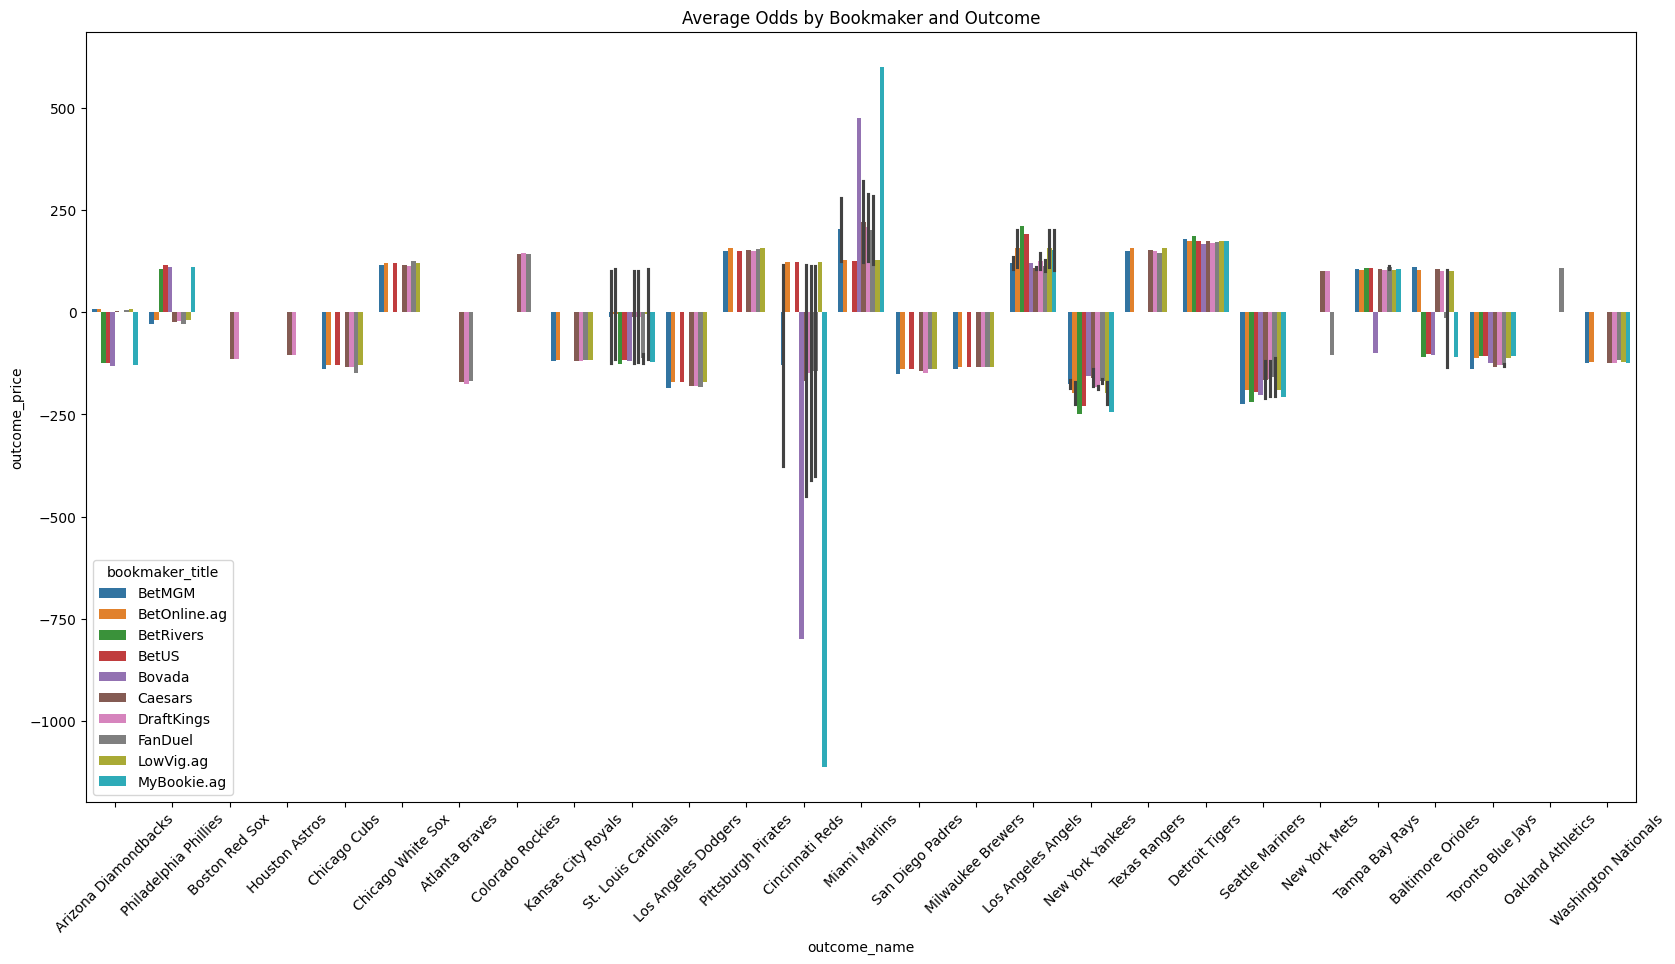

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=df_avg_odds, x='outcome_name', y='outcome_price', hue='bookmaker_title')
plt.title('Average Odds by Bookmaker and Outcome')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Groups and aggregates a processed Dataframe to find the average odds of each position of each market of each game
def av_odds(df):
    key_fields = ['sport_key', 'sport_title', 'home_team', 'away_team', 'market_key', 'outcome_name','outcome_price']

    # Aggregate by mean
    df = df.groupby(key_fields, dropna=False).mean()
    df.sort_values(['home_team', 'away_team', 'market_key'], inplace=True)
    return df


In [ ]:
# Extracts the pinnacle odds from processed odds (function will return an empty df if eu odds are not part of input df)
def extract_pinnacle(odds):
        pinnacle_odds = odds.loc[odds['book_key'] == 'pinnacle']
        pinnacle_odds.reset_index(drop=True, inplace=True)
        return pinnacle_odds


In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Calculates the expected value with regard to the average odds, takes just book_odds as parameter as average odds are calculated directly from book odds
def avg_ev(book_odds):
        # Calculate average odds
        average_odds = av_odds(book_odds)

        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'market', 'position', 'point', 'num_outcomes', 'num_books']

        # Merge book odds with the average odds
        avg_merge = book_odds.merge(average_odds, how='inner', on=key_fields, suffixes=['_book', '_avg'], validate='m:1')

        # Calculate ev data
        avg_merge['ev_pct_avg'] = (avg_merge['fair_win_dec_avg'] * avg_merge['amount_to_win_line_book']) - ((1 - avg_merge['fair_win_dec_avg']) * 100)
        avg_merge['kelly_dec_avg'] = avg_merge['fair_win_dec_avg'] - ((1 - avg_merge['fair_win_dec_avg']) / (avg_merge['amount_to_win_line_book'] / 100))
        avg_merge['kelly_pct_avg'] = avg_merge['kelly_dec_avg'] * 100

        return avg_merge

In [ ]:
# Merge the avg ev and pinnacle ev dataframes into one
def merge_ev(avg_merge, pinnacle_merge):
        # Key fields for merging
        key_fields = ['id', 'sport_key', 'sport_title', 'commence_time', 'home_team', 'away_team', 'book_key', 'book_title', 'market', 'position', 'line_book', 'point', 'num_outcomes', 'above_below_book', 'width_book', 'vig_win_dec_book', 'fair_win_dec_book', 'fair_line_book', 'amount_to_win_line_book', 'amount_to_win_fair_book', 'vig_dec_book', 'vig_pct_book']

        # Merge the dataframes (left merge because there are more averages than pinnacle odds and we don't want to lose those)
        final_merge = avg_merge.merge(pinnacle_merge.drop(columns=['num_books']), how='left', on=key_fields, suffixes=['_avg', '_pinnacle'])

        return final_merge

In [ ]:
# Takes API parameters and the desired type of expected value and returns a complete Dataframe with ev fields
def api_to_ev(api_key, sports=None, regions=['us'], markets=['h2h'], ev_type='both'):
        book_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=regions, markets=markets)

        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            if 'eu' not in regions:
                eu_odds = api_to_processed_df(api_key=api_key, sports=sports, regions=['eu'], markets=markets)
                pinnacle_odds = extract_pinnacle(eu_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            else:
                pinnacle_odds = extract_pinnacle(book_odds)
                pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Reads data from a JSON file and returns a complete Dataframe with ev fields (if ev_type 'pinnacle' is selected and file does not contain eu odds, df will be empty)
def file_to_ev(filename, ev_type='both'):
        book_odds = file_to_processed_df(filename)
        if ev_type == 'avg':
            ev = avg_ev(book_odds=book_odds)
        elif ev_type == 'pinnacle':
            pinnacle_odds = extract_pinnacle(book_odds)
            ev = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
        else: # assumed to be 'both'
            average = avg_ev(book_odds=book_odds)
            pinnacle_odds = extract_pinnacle(book_odds)
            pinnacle = pinnacle_ev(book_odds=book_odds, pinnacle_odds=pinnacle_odds)
            ev = merge_ev(avg_merge=average, pinnacle_merge=pinnacle)

        return ev

In [ ]:
# Filters a Dataframe of ev odds based on several optional parameters
def filter_ev(odds, pref_ev_filter, sports=None, markets=None, days_from_now=None, books=None, min_odds=None, max_odds=None, max_width=None, max_vig_pct=None, min_ev_pct=None, min_num_books=None):
        if sports is not None:
            odds = odds.loc[odds['sport_key'].isin(sports)]
        if markets is not None:
            odds = odds.loc[odds['market'].isin(markets)]
        if days_from_now is not None:
            date = pytz.UTC.localize(datetime.datetime.now())+datetime.timedelta(days=days_from_now)
            odds = odds.loc[odds['commence_time'].apply(lambda t: dateutil.parser.isoparse(t)) <=  date]
        if books is not None:
            odds = odds.loc[odds['book_key'].isin(books)]
        if min_odds is not None:
            odds = odds.loc[odds['line_book'] >= min_odds]
        if max_odds is not None:
            odds = odds.loc[odds['line_book'] <= max_odds]
        if max_width is not None:
            odds = odds.loc[odds['num_outcomes'] == 2]
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['width_avg'] <= max_width]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['width_pinnacle'] <= max_width]
        if max_vig_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['vig_pct_avg'] <= max_vig_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['vig_pct_pinnacle'] <= max_vig_pct]
        if min_ev_pct is not None:
            if pref_ev_filter == 'both' or pref_ev_filter == 'avg':
                odds = odds.loc[odds['ev_pct_avg'] >= min_ev_pct]
            if pref_ev_filter == 'both' or pref_ev_filter == 'pinnacle':
                odds = odds.loc[odds['ev_pct_pinnacle'] >= min_ev_pct]
        if min_num_books is not None:
            odds = odds.loc[odds['num_books'] >= min_num_books]

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Sorts a Dataframe of ev odds by a field
def sort_ev(odds, sortby, ascending, pref_ev_sort='avg'):
        if sortby == 'commence_time':
            odds.sort_values(['commence_time'], ascending=ascending, inplace=True)
        elif sortby == 'line':
            odds.sort_values(['line_book'], ascending=ascending, inplace=True)
        elif sortby == 'width':
            if pref_ev_sort == 'avg':
                odds.sort_values(['width_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['width_pinnacle'], ascending=ascending, inplace=True)
        elif sortby == 'ev_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['ev_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['ev_pct_pinnacle'], ascending=ascending, inplace=True)
        if sortby == 'kelly_pct':
            if pref_ev_sort == 'avg':
                odds.sort_values(['kelly_pct_avg'], ascending=ascending, inplace=True)
            if pref_ev_sort == 'pinnacle':
                odds.sort_values(['kelly_pct_pinnacle'], ascending=ascending, inplace=True)

        if sortby == 'default':
            odds.sort_values(['commence_time', 'id', 'book_key', 'market'], inplace=True)

        odds.reset_index(drop=True, inplace=True)

        return odds

In [ ]:
# Simplify the dataframe into a more easily consumable format
def cleanup_ev(odds, ev_type):
        fields_keep = ['sport_title', 'commence_time', 'home_team', 'away_team', 'book_title', 'market', 'position', 'line_book', 'point', 'num_books']

        if ev_type == 'both' or ev_type == 'avg':
            add_fields = ['fair_line_avg', 'width_avg', 'vig_pct_avg', 'ev_pct_avg', 'kelly_pct_avg']
            fields_keep.extend(add_fields)
        if ev_type == 'both' or ev_type == 'pinnacle':
            add_fields = ['fair_line_pinnacle', 'width_pinnacle', 'vig_pct_pinnacle', 'ev_pct_pinnacle', 'kelly_pct_pinnacle']
            fields_keep.extend(add_fields)


        odds = odds[fields_keep]
        odds = odds.round(2)
        return odds


In [ ]:
########################################################################################################################################
    #
    # BEGIN data() main code body
    #
    ########################################################################################################################################

    # Check inputs for api call and/or filename
if api_key is None and filename is None:
        raise SystemExit("Error: API key or filename must be specified\n")

if sports is None:
        if filename is None and api_key is not None:
            sports = get_sports(api_key=api_key)
elif sports is not None and (type(sports) != list or len(sports) == 0):
        raise TypeError("parameter 'sports' must be a list of valid sport IDs or None value. Refer to documentation for information on valid sport IDs\n")

if type(regions) != list or len(regions) == 0:
        raise TypeError("parameter 'regions' must be a list of valid regions. Refer to documentation for information on valid regions\n")

region_list = ['us']
for region in regions:
        if region not in region_list:
            raise SystemExit("Error: one or more regions are invalid. Refer to documentation for information on valid regions\n")

if type(markets) != list or len(markets) == 0:
        raise TypeError("parameter 'markets' must be a list of valid markets. Refer to documentation for information on valid markets\n")

market_list = ['h2h', 'spreads', 'totals']
for market in markets:
        if market not in market_list:
            raise SystemExit("Error: one or more markets are invalid. Refer to documentation for information on valid markets\n")

ev_types = ['avg', 'pinnacle', 'both']
if ev_type not in ev_types:
        raise SystemExit("Error: ev_type must be one of: 'avg', 'pinnacle', 'both' or be left blank")

NameError: name 'api_key' is not defined

In [ ]:
# Get ev data frame
    if filename is not None:
        df = file_to_ev(filename=filename, ev_type=ev_type)
    else:
        df = api_to_ev(api_key=api_key, sports=sports, regions=regions, markets=markets, ev_type=ev_type)

    # If recommended is on, reassign everything to values to give recommended bets (except books because a user should still be able to customize which books are displayed)
    if type(recommended) != bool:
        print("parameter 'recommended' must be a boolean. Default value is false")
        recommended = False
    if recommended:
        days_from_now = 2
        min_odds = -200
        max_odds = 200
        max_width = 45
        min_ev_pct = 1
        min_num_books = 4
        pref_ev_filter = 'both'
        sortby = 'ev_pct'
        ascending = False
        pref_ev_sort = 'avg'
        expanded = False

In [ ]:
# Check inputs for filter
    if days_from_now is not None and (type(days_from_now) != int or days_from_now < 0):
        if type(days_from_now) == float:
            days_from_now = int(days_from_now)
        else:
            print("parameter 'days_from_now' must be an integer >= 0. Filter parameter ignored")
            days_from_now = None

    if books is not None:
        if type(books) != list:
            print("parameter 'books' must be a list of valid book keys. Refer to documentation for information on valid books. Filter parameter ignored")
            books = None
        else:
            book_list = df['book_key'].unique().tolist()
            for book in list(books):
                if book not in book_list:
                    books.remove(book)
                    print(f'{book} is not a valid book. Data filtered by other specified books')
            if len(books) == 0:
                books = None

    if min_odds is not None and type(min_odds) != int and type(min_odds) != float:
        print("parameter 'min_odds' must be an integer or float. Filter parameter ignored")
        min_odds = None

    if max_odds is not None and type(max_odds) != int and type(max_odds) != float:
        print("parameter 'max_odds' must be an integer or float. Filter parameter ignored")
        max_odds = None

    if max_width is not None and type(max_width) != int and type(max_width) != float:
        print("parameter 'max_width' must be an integer or float. Filter parameter ignored")
        max_width = None

    if max_vig_pct is not None and type(max_vig_pct) != int and type(max_vig_pct) != float:
        print("parameter 'max_vig_pct' must be an integer or float. Filter parameter ignored")
        max_vig_pct = None

    if min_ev_pct is not None and type(min_ev_pct) != int and type(min_ev_pct) != float:
        print("parameter 'min_ev_pct' must be an integer or float. Filter parameter ignored")
        min_ev_pct = None

    if min_num_books is not None and type(min_num_books) != int and type(min_num_books) != float:
        print("parameter 'min_num_books' must be an integer or float. Filter parameter ignored")
        min_num_books = None

    if pref_ev_filter not in ev_types:
        print("parameter 'pref_ev_filter' must be one of: 'avg', 'pinnacle', 'both' or be left blank. Value defaults to 'both'")
        pref_ev_filter = 'both'
    elif pref_ev_filter == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_filter' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_filter = 'pinnacle'
    elif pref_ev_filter == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_filter' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_filter = 'avg'

    if ev_type == 'both':
        if pref_ev_filter is None:
            pref_ev_filter = 'both'
    else:
        pref_ev_filter = ev_type


In [ ]:
 # Filter the df
    df = filter_ev(df, pref_ev_filter, sports=sports, markets=markets, days_from_now=days_from_now, books=books, min_odds=min_odds, max_odds=max_odds, max_width=max_width, max_vig_pct=max_vig_pct, min_ev_pct=min_ev_pct, min_num_books=min_num_books)


In [ ]:
# Check inputs for sorting
    sort_options = ['commence_time', 'line', 'width', 'ev_pct', 'kelly_pct', 'default']
    if type(sortby) != str and sortby not in sort_options:
        print("parameter 'sortby' invalid. Refer to documentation for valid 'sortby' values. Filter parameter ignored")
        sortby = 'default'

    if ascending is not None and type(ascending) != bool:
        print("parameter 'ascending' must be a boolean. Default value used")
        ascending = False

    if pref_ev_sort is not None and (pref_ev_sort not in ev_types or pref_ev_sort == 'both'):
        print("parameter 'pref_ev_sort' must be 'avg' or 'pinnacle' or be left blank. Value defaults to 'avg'")
        pref_ev_sort = 'avg'
    elif pref_ev_sort == 'avg' and ev_type == 'pinnacle':
        print("parameter 'pref_ev_sort' cannot be 'avg' when parameter 'ev_type' is 'pinnacle'. Value defaults to 'pinnacle'")
        pref_ev_sort = 'pinnacle'
    elif pref_ev_sort == 'pinnacle' and 'ev_type' == 'avg':
        print("parameter 'pref_ev_sort' cannot be 'pinnacle' when parameter 'ev_type' is 'avg'. Value defaults to 'avg'")
        pref_ev_sort = 'avg'


In [ ]:
# Sort the df
    df = sort_ev(df, sortby=sortby, ascending=ascending, pref_ev_sort=pref_ev_sort)

In [ ]:
# If expanded is false, simplify the df
    if type(expanded) != bool:
        print("parameter 'expanded' must be a boolean. Value defaults to false.")
    if not expanded:
        df = cleanup_ev(df, ev_type=ev_type)

    return df